# C2HO Creative Computing Competition 2023, Oslo

#### The script generates audio-visual artwork by sonifying and visualizing brain activity recorded in the cortex of an awake/unconscious mouse. 

#### The input data represent the timing of electrical impulses recorded simultaneously across superficial and deep layers of the mouse cortex. 

#### The location and electrical activity of each recording position is visualized by plotting  a series of vertically arranged circles, which vary in color and size depending on the rate of electrical impulses (superficial layers correspond to circles at the top, deep layers to circles on the bottom). Plots are converted to a mp4 video file. 

#### For sonification, data are mapped to MIDI notes and converted to a .wav file. Finally, audio and video files are merged (mp4).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
import cv2
import glob
import re
%matplotlib inline

# Functions

In [19]:

def sum_spikes_window (rasterplot, sampling_rate= 20000, bin_step_ms = 5, factor = 4):
    """returns ratio:  The sum of spikes (ones) in a moving bin_window / length of bin_window. The bin_window is a factor (by default 4) x the size of the bin_step and moves in bin_step increments towards the end of the recording. 
    
    Parameters:
    -----------
    rasterplot: input data array (channels x samples) 
    
    sampling_rate: the sampling rate of the input data array (default = 20000 samples/s)
    
    bin_step_ms: (int) the bin step in milli seconds
    
    factor: by default = 4, determines size of the bin window: bin_window = factor x bin_step_ms  
      
    
    """
    
        
        
    ###Parameters for testing, delete after function finished!!!!
    #rasterplot = arr_rs
    #sampling_rate= srate1
    #bin_step_ms = 5
    #factor = 4
    
    
    
    
    
    #number of sample points before/after stimulation: interval
    interval = np.size(rasterplot, axis = 1)
    
    #number of sample points before stimulation: interval_half (scalar)
    interval_half = ((np.size(rasterplot, axis = 1)-1)/sampling_rate)/2
    
    #convert bin_step_ms to bin_step in samples: bin_step
    bin_step = int((bin_step_ms/1000) * sampling_rate)
    
        
    #define first how large window for sum should be: store in bin list and bin step, np.arange-->from 0 to value which is sum of x and y sample point ####
    bin_list = np.arange(0,interval + bin_step, bin_step).tolist()
    
          
    #del last 4 values of bin_list to avoid being out of bounds in following loop#######
    del bin_list[-factor:] 
    
    
    ###########sum spikes over given binwindow (binstep x 4, e.g. 30 samples is 1 ms, ) s#####
    #defines size of bin_window
    bin_window = bin_step*factor
    #empty array (bin_list channels x samples): sum_bins
    sum_bins = np.zeros((np.size(rasterplot, axis = 0), len(bin_list)))
    for i in range (np.size(rasterplot, axis =0)): 
        for ii in range(len(bin_list)):
            x = bin_list[ii]
            y = bin_list[ii] + bin_window
            sum_bins[i,ii]= np.sum(rasterplot[i, x:y])
    # ratio sum_bins/len(bin_window): ratio
    ratio = sum_bins/bin_window
    return ratio
    
    

def find_closest_value(arr, val):
    """
    

    Parameters
    ----------
    arr : input array (1-D)
    val : integer

    Returns
    the index of a value in array closest to the input value
    
    """
    return np.abs(arr - val).argmin()



def get_circle_props(ones_ratio):
    """returns float numbers for diameter and color of an input array used in plot function
    arr: 2D numpy array (channels x samples) returned by sum_spikes_window"""
    
    #ones_ratio  = np.sum(arr) / np.size(arr)
    diameter    =   ones_ratio 
    #color (red, green, blue), tuple with floats from 0 to 1
    color       = (ones_ratio, np.array([0]), 1-ones_ratio)
    return diameter, color    


def map_value(value, min_value, max_value, min_result, max_result):
    '''maps value (or array of values) from one range to another'''
    
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

def sort_nicely( l ): 
    """ Sort the given list in the way that humans expect.
    https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside?noredirect=1&lq=1
    """ 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    l.sort( key=alphanum )

""" Sort the given list in the way that humans expect.
https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside?noredirect=1&lq=1
""" 
convert = lambda text: int(text) if text.isdigit() else text 
alphanum = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 


def plot_save_img(diameter, color, ncol, title1, title2, title_change ,fpath):
    """plots rate ratio (returned by  def sum spikes window ) function as a change in diameter and color
    (returned by def get_circle_props) and saves images to file path
    
    Parameters:
    ----------
    
    diameter: nd array (channels x samples), controls diameter of circle, returned by  def sum spikes window 
    
    color   : nd array (channels x samples), controls diameter of circle, returned by  def sum spikes window 

    gridspec: gridspecobject passed to subplots
    
    ncol    : (int) repeat the signal for n columns
    
    title1  : (string) title 1 of the figure
    
    title2  : (string) title 2 of the figure

    title_change: (int) the image number when title 2 is displayed

    fpath   : filepath (string), where images are saved    
    """
    #test
    #diameter, color = dia, col
    
    
    #the number of channels/circles in the yaxis of the plot
    nrow = dia.shape[0]
    #repeat the rows in x direction of plot for ncol
    #ncol = 2



   #a grid layout to place subplots in a figure while adjusting for space and margins in between
    gs = gridspec.GridSpec(nrow, ncol,
        wspace=0.0, hspace=0.0, 
        top=1-0.5/(nrow+1), bottom=0.5/(nrow+1), 
        left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 
        
 
    #loop over axis=1 in diameter, i.e. the number of images to be created
    for img in range (np.size(diameter, axis = 1)):
        #initiate figure and size for every iteration
        fig = plt.figure(figsize=(8*ncol+1, nrow+1))
        
        if title_change >= img:
            fig.suptitle(title1, color="white", fontsize=40)
        if title_change <  img:
            fig.suptitle(title2, color ="white", fontsize=40)

        #the number of rows (i) in the plot, corresponding to channels in y-axis
        for i in range(nrow):
            for j in range(ncol):
                ax= plt.subplot(gs[i,j])
                #color has three indices, [0] = red, [1] = green, [2] = blue; for each channel (axis0) and image(axis1) one RGB tuple is selected, green is set to 0 
                
                red   = color[0][i][img]
                green = color[1][0] #has only one value, i.e. 0
                blue  = color[2][i][img]
                color_ = red, green, blue
                

                circle= plt.Circle((0,0), diameter[i,img], color=color_)
                ax.add_artist(circle)
                ax.set_xlim(-1,1)
                ax.set_ylim(-1,1)
    
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                ax.set_facecolor('black')
        plt.savefig(fpath + str (img) + ".png", format="png", bbox_inches="tight", pad_inches = 0 )
        plt.close()


def NoteToMidi(KeyOctave):
    # KeyOctave is formatted like 'C#3'
    NOTES_FLAT = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
    NOTES_SHARP = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    key = KeyOctave[:-1]  # eg C, Db
    octave = KeyOctave[-1]   # eg 3, 4
    answer = -1

    try:
        if 'b' in key:
            pos = NOTES_FLAT.index(key)
        else:
            pos = NOTES_SHARP.index(key)
    except:
        print('The key is not valid', key)
        return answer

    answer += pos + 12 * (int(octave) + 1) + 1
    return answer



## 1) Load data stored in numpy arrays 

In [24]:
#load data (wake mouse)
arr = np.load('/Users/chrihoni/A10_rec1_wake_channels_samples_trials_140423_A10_MUA_analysis_for_creative_comp__.npy')
#load data (anesthetized mouse)
arr2 = np.load('/Users/chrihoni/A10_rec2_anesthetized_channels_samples_trials_140423_A10_MUA_analysis_for_creative_comp__.npy')

#load raster plot time vector 
time1 = np.load("/Users/chrihoni/time_vector140423_A10_MUA_analysis_for_creative_comp__.npy")

#sampling rate of data (samples/second, Hz)
srate1 = 25000

print("The shape of the arrays (channels, samples, trials): ")
print(arr.shape)
print(arr2.shape)

print("The samples correspond to a time vector ranging from: " + str(time1[0]) + " to " +  str(time1[-1]) + " seconds")


The shape of the arrays (channels, samples, trials): 
(25, 150001, 10)
(25, 150001, 10)
The samples correspond to a time vector ranging from: -3.0 to 3.0 seconds


## 2) Select data

We do not use the whole time range and trials and select instead a subset of data to work with. 

In [31]:
#find indices of selected time range in time array 
ix1 = find_closest_value(time1, -0.3)
ix2 = find_closest_value(time1, 0.7)

#slice array axis 1 (channels x samples x trials) according to start stop indices
arr_sl  =  arr  [:,ix1:ix2, 6:8]
arr2_sl =  arr2 [:,ix1:ix2, 6:8]

print(f"original shape (channels, samples, trials): {arr_sl.shape}")

#reshape the array from (channels x samples x trials) to (channels x (samples x trials)), i.e. the trials should be flattened and be in the same dimension
arr_rs = np.reshape (arr_sl,   (np.size(arr_sl, axis = 0),  np.size(arr_sl, axis =1)  *  np.size(arr_sl, axis =2)))
arr2_rs = np.reshape (arr2_sl, (np.size(arr2_sl, axis = 0), np.size(arr2_sl, axis =1) *  np.size(arr2_sl, axis =2)))

print(f"new shape (channels, samples): {arr_rs.shape}")


original shape (channels, samples, trials): (25, 25000, 2)
new shape (channels, samples): (25, 50000)


## 3) Calculate spike rates and return color and size paramters

We calculate the spike ratio, i.e. the average rate over consecutive small time windows
(number of spikes/length of time window) for awake and unconscious condition.

The files are then concatenated (starting with the awake condition), 
and ratios are then mapped to values from 0 to 1. The ratios are then passed to a function which returns diameter and color arrays. These control the size and color of circles representing electrical activity of recording positions across the cortical depth.



In [33]:
#get spike ratio array by summing spikes in a moving window
ratio_wake = sum_spikes_window (arr_rs,  sampling_rate= srate1, bin_step_ms = 5, factor = 4)  
ratio_anes = sum_spikes_window (arr2_rs, sampling_rate= srate1, bin_step_ms = 5, factor = 4)  

#concatenate ratio wake and ratio anes 
ratio_w_a = np.concatenate((ratio_wake, ratio_anes), axis =1)

#map spike ratio to values from 0 to 1
ratio_map = map_value(ratio_w_a, np.min(ratio_w_a), np.max(ratio_w_a), 0, 1)


#get diameter and color of each channel and image
dia, col = get_circle_props(ratio_map)


## 4) Plot and save images for all time windows

In [34]:
#parameters passed to plot function

#path for saving images
fig_savepath  = "/Users/chrihoni/images_C2HO/rec1_2_trial6to7/img"

#the number of channels/circles in the yaxis of the plot
nrow = dia.shape[0]
#repeat the rows in x direction of plot for ncol, default =1
ncol = 1

#plot and save images
start = time.time()
plot_save_img(dia, col, 1, "AWAKE", "UNCONSCIOUS", np.size(ratio_wake, axis=1), fig_savepath)
end = time.time()
print(end - start)


592.4476640224457


## 5) Create video from images

In [35]:
#the number of frames/images per second
fps = 20
#the number of images
img_nr = np.size(ratio_w_a, axis = 1)

img_array = []
for filename in sorted(glob.glob('/Users/chrihoni/images_C2HO/rec1_2_trial6to7/*.png'), key=alphanum):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    
    img_array.append(img)
 

out = cv2.VideoWriter('/Users/chrihoni/images_C2HO/rec1_2_trial6to7/rec1_2_.mp4',cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
#out1 = cv2.VideoWriter('rec1_2_.mp4',-1, fps, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release() 


## 6) Sonify data

To keep it simple we want to select some data and not sonify and play all 25 channels at the same time may!! Instead we select from all channels for a given timepoint the maximum rate. In this way we can extract sound from the most active site at a given time point while sampling from different positions over time. 

We plot these data first, to explore variations of our max rates over time.

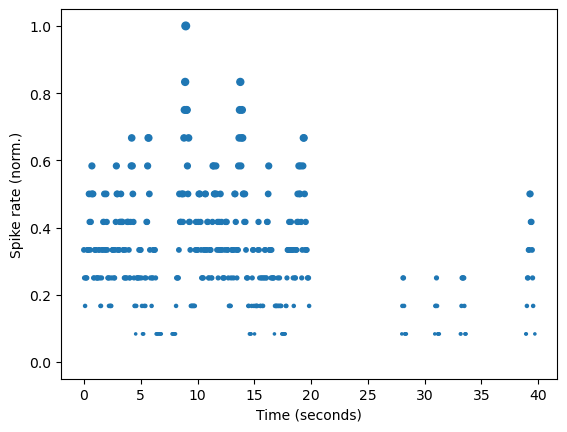

In [36]:
# plot data

#the number of frames/images per second
fps = 20
#the number of images
img_nr = np.size(ratio_w_a, axis = 1)

#x axis (time): the duration of the video file; the number of images/frames per second
dur = img_nr/fps
time = np.linspace(0, dur, img_nr)
ratio_max = np.max(ratio_map, axis =0)

plt.scatter(time, np.max(ratio_map, axis =0), s = 30*np.max(ratio_map, axis =0))
plt.xlabel("Time (seconds)")
plt.ylabel("Spike rate (norm.)")
plt.show()


## 7) Choose musical notes for pitch mapping, convert to midi numbers

To convert notes to midi notes we refer to the excellent tutorial of Matt Russo - "How to turn data into music"
https://astromattrusso.gumroad.com/l/data2music-part1
https://github.com/SYSTEMSounds/sonification-tutorials/blob/main/data2midi-part1.ipynb

The notes in note_names correspond to the following MIDI notes: [24, 36, 43, 48, 52, 55, 57, 59, 62, 64, 67, 69, 71, 74, 76, 79, 81, 83, 86, 88, 90, 91, 93]
Resolution: 23 notes


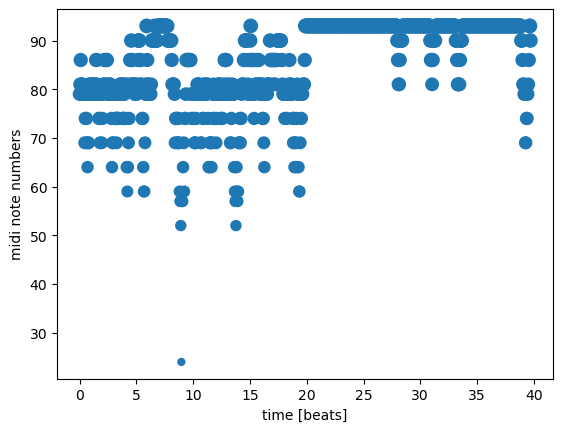

In [42]:
#custom note set (a voicing of a Cmaj13#11 chord, notes from C lydian)
note_names3 = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']


note_midis = [NoteToMidi(n) for n in note_names3] #make a list of midi note numbers 
print(f"The notes in note_names correspond to the following MIDI notes: {note_midis}")


n_notes = len(note_midis)
print('Resolution:',n_notes, 'notes')

#Map data to MIDI note numbers (map higher spike rates to lower notes)
n_val = len(time)
midi_data = []
for i in range(n_val):
    note_index = round(map_value(ratio_max[i], 0, 1, n_notes-1, 0)) #notice choice of polarity: higher rates are mapped to lower notes
                                                        #we round the result because it's a list index which must be an integer
    midi_data.append(note_midis[note_index])

plt.scatter(time, midi_data, s=midi_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

## 8) Map data to note velocities (map higher spike rates to greater velocities)

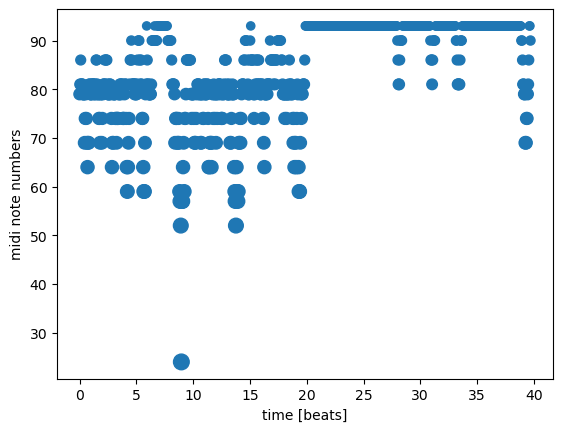

In [45]:
#midi velocity (integer from 0-127) is a combination of volume and intensity (hitting a piano key with a larger velocity makes a louder, more intense sound)
#the same data are used to control the note pitch and the note velocity 

n_val = len(time)
vel_min,vel_max = 35,127   #minimum and maximum note velocity

vel_data = []
for i in range(n_val):
    note_velocity = round(map_value(ratio_max[i], 0, 1, vel_min, vel_max)) #bigger craters will be louder
                                                                #we round here because note velocites are integers
    vel_data.append(note_velocity)
    
plt.scatter(time, midi_data, s=vel_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

## 9) Save data as midi file

In [46]:
from midiutil import MIDIFile #import library to make midi file, https://midiutil.readthedocs.io/en/1.2.1/
#the midi file measures time in beats (quarter notes), for 1 beat/second set beats per minute to 60
bpm = 60
#create midi file object, add tempo
my_midi_file = MIDIFile(1) #one track 
my_midi_file.addTempo(track=0, time=0, tempo=bpm) 

#add midi notes
for i in range(n_val):
    my_midi_file.addNote(track=0, channel=0, pitch=midi_data[i], time=time[i], duration=2, volume=vel_data[i])
filename = "/Users/chrihoni/rec1_2"
#create and save the midi file itself
with open(filename + '.mid', "wb") as f:
    my_midi_file.writeFile(f) 

In [47]:
#listen to the midi file
#import pygame
#filename = "/Users/chrihoni/rec1_2"

#pygame.init()
#pygame.mixer.music.load(filename + '.mid')
#pygame.mixer.music.play()


## 10) Convert midi file to .wav and concatenate audio and video files (sonified and visualized rates)

In [52]:
from moviepy.editor import VideoFileClip, AudioFileClip, concatenate_videoclips
from pydub import AudioSegment
import os

from midi2audio import FluidSynth

#font paths downloaded from https://www.zanderjaz.com/downloads/soundfonts/
font_path = "/Users/chrihoni/Downloads/198_Yamaha_SY1_piano.sf2"
font_path2 = "/Users/chrihoni/default_sound_font.sf2"
font_path3 = "/Users/chrihoni/Downloads/RolandNicePiano.sf2"
font_path4 = "/Users/chrihoni/Downloads/Piano.SF2"
font_path5 = "/Users/chrihoni/Downloads/1115_Korg_IS50_Marimboyd.sf2"
font_path6 = "/Users/chrihoni/Downloads/YAMAHA DX7Piano.SF2"
font_path7 = "/Users/chrihoni/Downloads/Stein Grand Piano.SF2"


#synthetize audio object using font path 
fs = FluidSynth(sound_font=font_path7, sample_rate=22050)

#convert midi file to .wav
#the path of the midi file
midi_path = "/Users/chrihoni/rec1_2.mid"
#the path of the output .wav file
wav_path =  "/Users/chrihoni/rec1_2_audio_font7.wav"
fs.midi_to_audio(midi_path, wav_path)

#the path of the file
#wav_path = "/Users/chrihoni/rec1_2_audio_font7.wav"
#play the midi file
#fs.play_midi(midi_path)
#the path of the output .mp3 file
#mp3_path =  "/Users/chrihoni/rec1_2_audio.mp3"
#fs.midi_to_audio(midi_path, wav_path)

#read midi file, convert and save
#audio = AudioSegment.from_file(wav_path, format="wav")
#audio.export (mp3_path, format ="mp3")


#convert video, .avi to .mp4
#video= VideoFileClip("/Users/chrihoni/images_C2HO/rec1_2_trial6to7/rec1_2.avi")
#video.write_videofile("/Users/chrihoni/images_C2HO/rec1_2_trial6to7/rec1_2.mp4")


#open video and audio
video_clip = VideoFileClip("/Users/chrihoni/images_C2HO/rec1_2_trial6to7/rec1_2_.mp4")
audio_clip = AudioFileClip("/Users/chrihoni/rec1_2_audio_font7.wav")

#concatenate video with audio clip
audio_video_clip = video_clip.set_audio(audio_clip)

#the path for saving
path = "/Users/chrihoni/rec1_2_audio_video_050523.mp4"

#export the  audio video file
audio_video_clip.write_videofile(path, audio_codec="aac")



fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: warning: No preset found on channel 9 [bank=128 prog=0]
fluidsynth: panic: An error occurred while reading from stdin.


FluidSynth runtime version 2.3.2
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file '/Users/chrihoni/rec1_2_audio_font7.wav'..
Moviepy - Building video /Users/chrihoni/rec1_2_audio_video_050523.mp4.
MoviePy - Writing audio in rec1_2_audio_video_050523TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /Users/chrihoni/rec1_2_audio_video_050523.mp4



Moviepy - Done !
Moviepy - video ready /Users/chrihoni/rec1_2_audio_video_050523.mp4
